# Formação Cientista de Dados
### Projeto com Feedback 4
### Prevendo Customer Churn em Operadoras de Telecom

### Gabriel Quaiotti - Abr 2020

Customer Churn (ou Rotatividade de Clientes, em uma tradução livre) refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da receita. Portanto, é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto, você deve prever o Customer Churn em uma Operadora de Telecom.

Os datasets de treino e de teste serão fornecidos para você em anexo a este projeto. Seu trabalho é criar um modelo de aprendizagem de máquina que possa prever se um cliente pode ou não cancelar seu plano e qual a probabilidade
de isso ocorrer. O cabeçalho do dataset é uma descrição do tipo de informação em cada coluna.

Usando linguagem Python, recomendamos você criar um modelo de Regressão Logística, para extrair a informação se um cliente vai cancelar seu plano (Sim ou Não) e a probabilidade de uma opção ou outra.

In [61]:
# Libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import col

from seaborn import pairplot
from seaborn import FacetGrid
from seaborn import heatmap
from seaborn import diverging_palette

import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

from numpy import triu
from numpy import ones_like

In [62]:
# Spark Session - usado para trabalhar com o Spark
spSession = SparkSession.builder.master("local").appName("DSA-TELECOM-FEATURE-SELECTION-1").getOrCreate()

# FEATURE SELECTION

In [63]:
# Read train dataset
# scaled_rdd = sc.textFile('../dataset/df_scaled_1.csv')
# scaled_rdd = sc.textFile('../dataset/df_scaled_0.csv')
scaled_rdd = sc.textFile('../dataset/df_standard.csv')

In [64]:
scaled_rdd.take(5)

['id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id',
 '10.0,0.9721807152053628,2.2014212203111105,1.8398222374529931,2.3360971017346266,1.0896917903776833,-0.8045873450182823,1.0894503003946745,0.31180037049114206,0.5302855487519631,0.3117714141662552,2.5175274904562177,-0.14664176158889883,2.518201254971893,0.2913441838047756,-0.029968116426965553,0.28543402580996596,-0.6613633377187209,0.0,-1.5651391304775844,-0.9265406747463913',
 '15.0,-1.0180295921891367,-0.4537898957205725,-0.5429778408293419,-0.5228883179359579,-1.1588572700838589,-1.4885114365650134,-1.1588140472057444,1.9758827984652125,-1.2134279468813545,1.9754405873059246,0.01320063930109094,-0.04433597617946641,0.015400369474970994

In [65]:
# Remove header and split by ','
header = scaled_rdd.first()
scaled_rdd2 = scaled_rdd.filter(lambda line: line != header).map(lambda line: line.split(","))

In [66]:
# Define the dataFrame columns
scaled_fields = [StructField("id", StringType(), True), 
     StructField("account_length", StringType(), True),
     StructField("international_plan", StringType(), True),
     StructField("voice_mail_plan", StringType(), True),
     StructField("number_vmail_messages", StringType(), True),
     StructField("total_day_minutes", StringType(), True),
     StructField("total_day_calls", StringType(), True),
     StructField("total_day_charge", StringType(), True),
     StructField("total_eve_minutes", StringType(), True),
     StructField("total_eve_calls", StringType(), True),
     StructField("total_eve_charge", StringType(), True),
     StructField("total_night_minutes", StringType(), True),
     StructField("total_night_calls", StringType(), True),
     StructField("total_night_charge", StringType(), True),
     StructField("total_intl_minutes", StringType(), True),
     StructField("total_intl_calls", StringType(), True),
     StructField("total_intl_charge", StringType(), True),
     StructField("number_customer_service_calls", StringType(), True),
     StructField("churn", StringType(), True),
     StructField("state_id", StringType(), True),
     StructField("area_code_id", StringType(), True)]

In [67]:
# Define the dataFrame schema
scaled_schema = StructType( scaled_fields )

In [68]:
# Create dataFrame
scaled_ds = spSession.createDataFrame(scaled_rdd2, scaled_schema)

In [69]:
scaled_ds = scaled_ds.withColumn('id', col('id').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('account_length', col('account_length').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('international_plan', col('international_plan').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('voice_mail_plan', col('voice_mail_plan').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('number_vmail_messages', col('number_vmail_messages').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_day_minutes', col('total_day_minutes').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_day_calls', col('total_day_calls').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_day_charge', col('total_day_charge').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_eve_minutes', col('total_eve_minutes').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_eve_calls', col('total_eve_calls').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_eve_charge', col('total_eve_charge').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_night_minutes', col('total_night_minutes').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_night_calls', col('total_night_calls').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_night_charge', col('total_night_charge').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_intl_minutes', col('total_intl_minutes').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_intl_calls', col('total_intl_calls').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('total_intl_charge', col('total_intl_charge').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('number_customer_service_calls', col('number_customer_service_calls').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('churn', col('churn').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('state_id', col('state_id').cast(DoubleType()))
scaled_ds = scaled_ds.withColumn('area_code_id', col('area_code_id').cast(DoubleType()))

In [70]:
scaled_ds

DataFrame[id: double, account_length: double, international_plan: double, voice_mail_plan: double, number_vmail_messages: double, total_day_minutes: double, total_day_calls: double, total_day_charge: double, total_eve_minutes: double, total_eve_calls: double, total_eve_charge: double, total_night_minutes: double, total_night_calls: double, total_night_charge: double, total_intl_minutes: double, total_intl_calls: double, total_intl_charge: double, number_customer_service_calls: double, churn: double, state_id: double, area_code_id: double]

In [71]:
scaled_ds.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
0,10.0,0.972181,2.201421,1.839822,2.336097,1.089692,-0.804587,1.089450,0.311800,0.530286,...,2.517527,-0.146642,2.518201,0.291344,-0.029968,0.285434,-0.661363,0.0,-1.565139,-0.926541
1,15.0,-1.018030,-0.453790,-0.542978,-0.522888,-1.158857,-1.488511,-1.158814,1.975883,-1.213428,...,0.013201,-0.044336,0.015400,0.953722,0.281315,0.956867,1.088035,0.0,1.877238,-0.926541
2,23.0,0.695063,-0.453790,-0.542978,-0.522888,-0.143015,0.563261,-0.143067,-2.600344,-0.067559,...,-0.417040,-1.118547,-0.417517,-0.301310,9.478302,-0.295614,-0.661363,0.0,0.331681,-0.926541
3,39.0,0.846218,2.201421,1.839822,2.027018,0.197773,0.270151,0.197434,-0.360083,-0.067559,...,-2.042620,0.364887,-2.040955,0.047310,0.281315,0.053015,0.322673,0.0,1.666480,-0.926541
4,45.0,-0.967645,-0.453790,-0.542978,-0.522888,-0.615879,-1.635067,-0.615931,0.386020,0.879028,...,1.277541,-0.709324,1.278075,-2.393030,-0.482743,-2.387387,-0.552026,0.0,-1.284129,0.278207


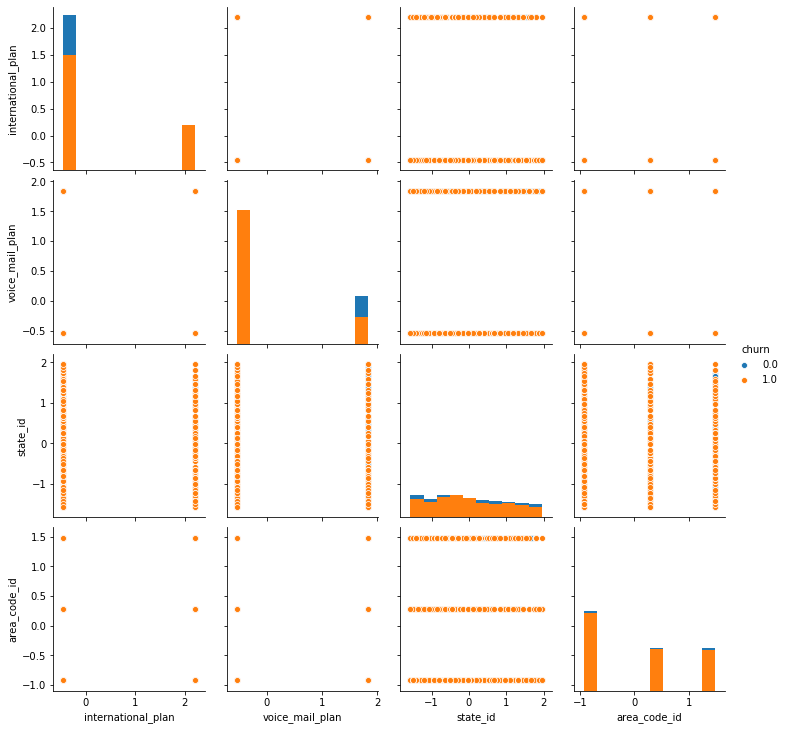

In [72]:
# Explore
pairplot(
    scaled_ds[
        'international_plan',
        'voice_mail_plan',
        'state_id',
        'area_code_id',
        'churn'
    ].toPandas(), 
    hue='churn', 
    diag_kind='hist')

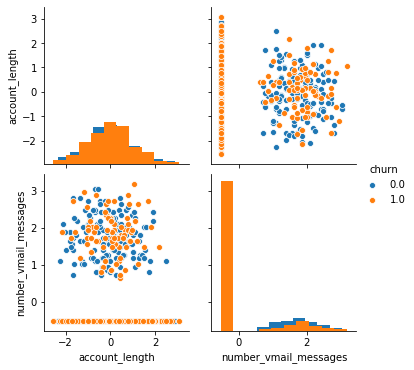

In [73]:
# Explore
pairplot(
    scaled_ds[
        'account_length',
        'number_vmail_messages',
        'churn'
    ].toPandas(), 
    hue='churn', 
    diag_kind='hist')

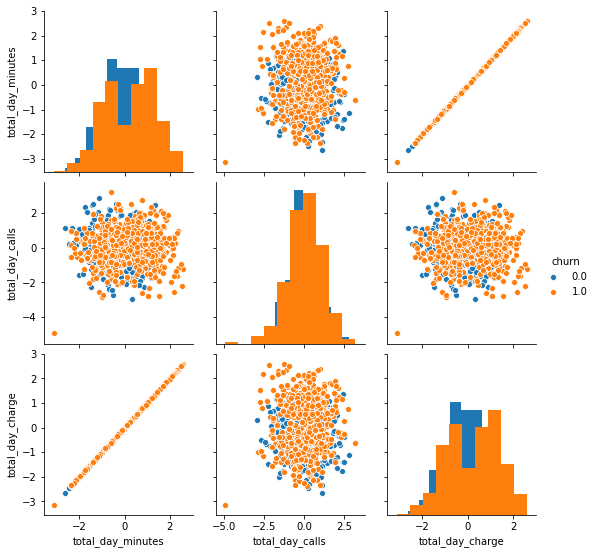

In [74]:
# Explore
pairplot(
    scaled_ds[
        'total_day_minutes',
        'total_day_calls',
        'total_day_charge',
        'churn'
    ].toPandas(), 
    hue='churn', 
    diag_kind='hist')

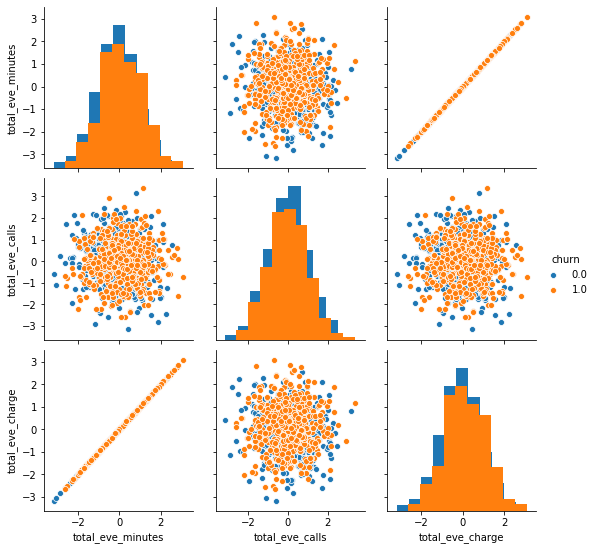

In [75]:
# Explore
pairplot(
    scaled_ds[
        'total_eve_minutes',
        'total_eve_calls',
        'total_eve_charge',
        'churn'
    ].toPandas(), 
    hue='churn', 
    diag_kind='hist')

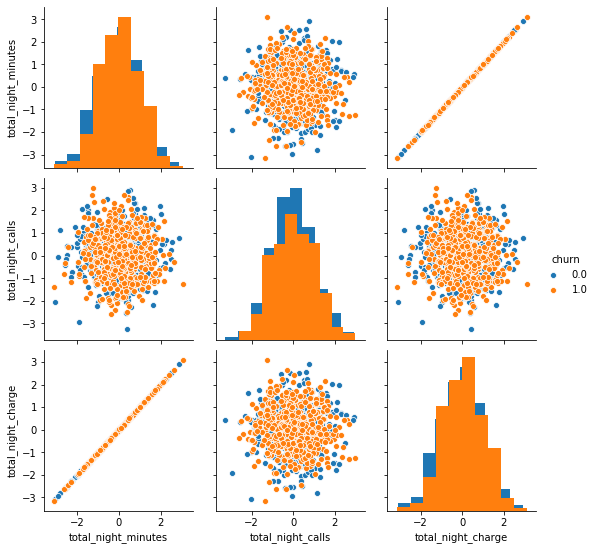

In [76]:
# Explore
pairplot(
    scaled_ds[
        'total_night_minutes',
        'total_night_calls',
        'total_night_charge',
        'churn'
    ].toPandas(), 
    hue='churn', 
    diag_kind='hist')

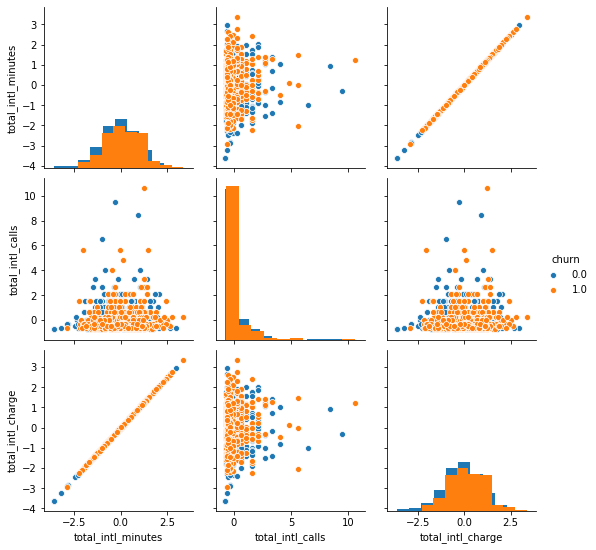

In [77]:
# Explore
pairplot(
    scaled_ds[
        'total_intl_minutes',
        'total_intl_calls',
        'total_intl_charge',
        'churn'
    ].toPandas(), 
    hue='churn', 
    diag_kind='hist')

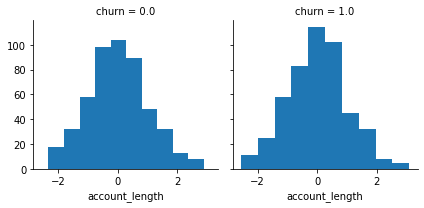

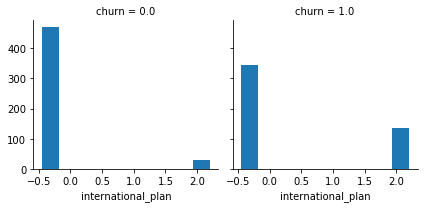

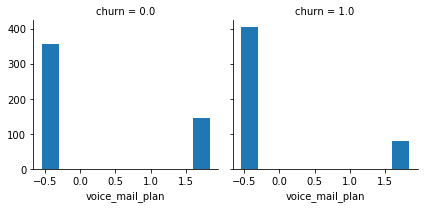

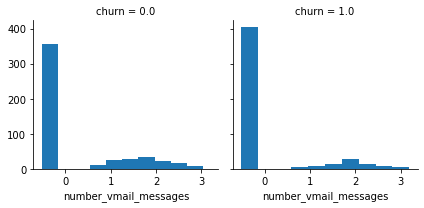

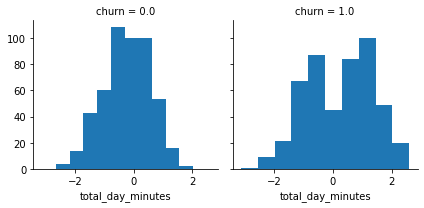

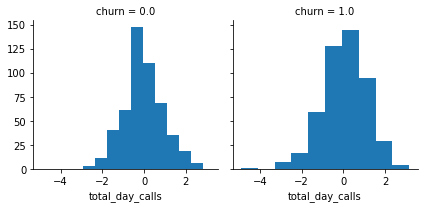

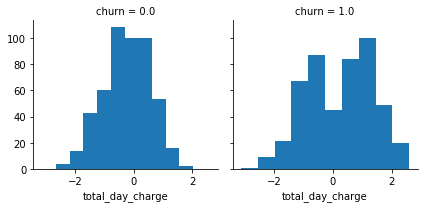

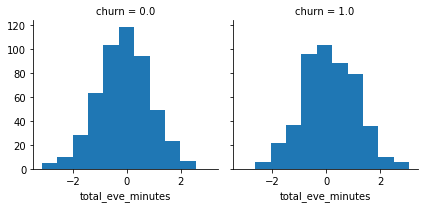

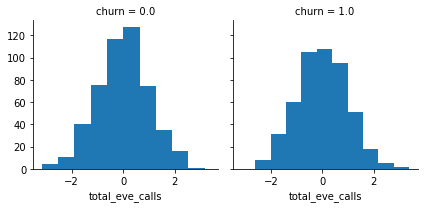

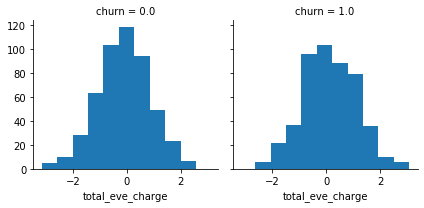

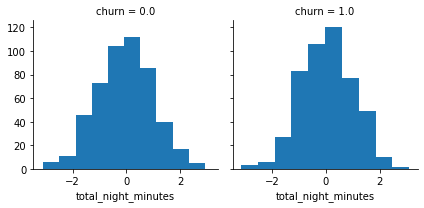

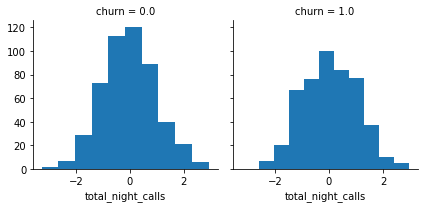

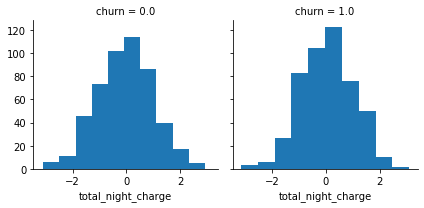

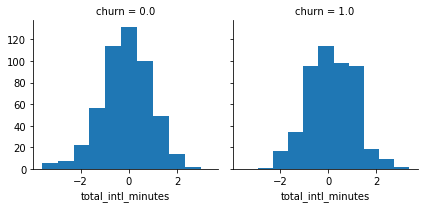

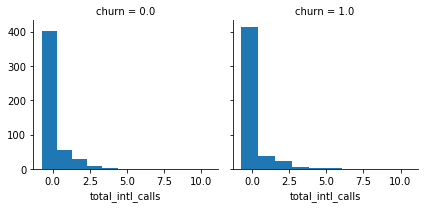

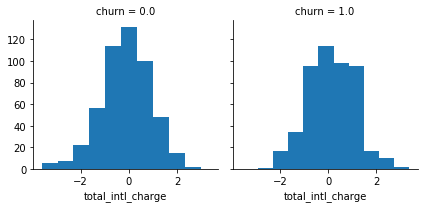

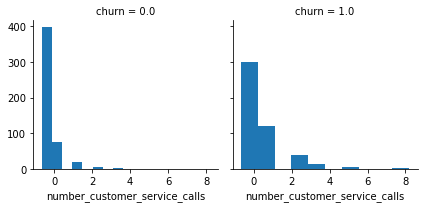

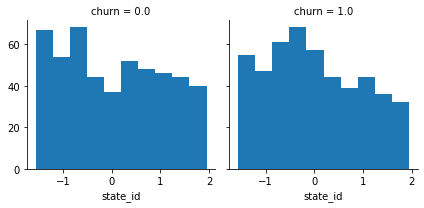

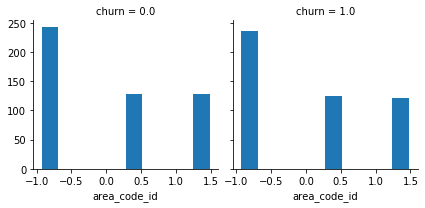

In [78]:
# View histogram for each column
for col in scaled_ds.toPandas().drop(['id', 'churn'], axis=1):
    g = FacetGrid(scaled_ds.toPandas(), col="churn")
    g.map(plt.hist, col)
    plt.pause(0.05)
    
plt.show()

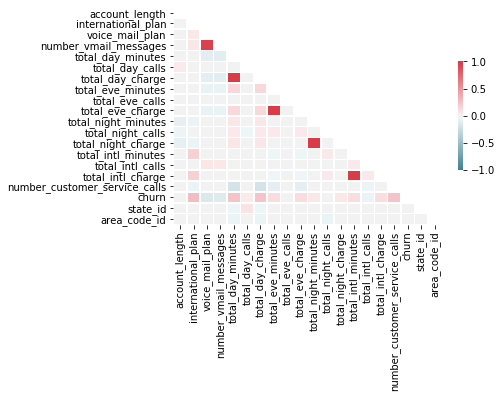

In [79]:
# Plot the correlations
corr = scaled_ds.drop('id').toPandas().corr()
mask = triu(ones_like(corr, dtype = bool))
cmap = diverging_palette(220, 10, as_cmap=True)
heatmap(corr, linewidths=.5, cbar_kws={"shrink": .5}, mask=mask, vmin=-1, vmax=1, cmap=cmap)

In [80]:
# Correlation with churn column
for i in scaled_ds.drop('id', 'churn').columns:
    print('Correlation between churn and', i, scaled_ds.corr('churn', i))

Correlation between churn and account_length 0.006307910994534634
Correlation between churn and international_plan 0.2943614208912339
Correlation between churn and voice_mail_plan -0.14584226934464664
Correlation between churn and number_vmail_messages -0.12545632246139965
Correlation between churn and total_day_minutes 0.24280888342118204
Correlation between churn and total_day_calls 0.041573186256194126
Correlation between churn and total_day_charge 0.2428087289424422
Correlation between churn and total_eve_minutes 0.12242381813356974
Correlation between churn and total_eve_calls 0.010044324633283768
Correlation between churn and total_eve_charge 0.12241431013286018
Correlation between churn and total_night_minutes 0.057517462493400597
Correlation between churn and total_night_calls 0.026803154894532274
Correlation between churn and total_night_charge 0.05750570158384518
Correlation between churn and total_intl_minutes 0.11508594890207624
Correlation between churn and total_intl_call

In [81]:
# Convert predictor columns to vector
vector_ds = VectorAssembler(inputCols=scaled_ds.drop('id', 'churn').columns, outputCol="features").transform(scaled_ds)

In [82]:
vector_ds

DataFrame[id: double, account_length: double, international_plan: double, voice_mail_plan: double, number_vmail_messages: double, total_day_minutes: double, total_day_calls: double, total_day_charge: double, total_eve_minutes: double, total_eve_calls: double, total_eve_charge: double, total_night_minutes: double, total_night_calls: double, total_night_charge: double, total_intl_minutes: double, total_intl_calls: double, total_intl_charge: double, number_customer_service_calls: double, churn: double, state_id: double, area_code_id: double, features: vector]

In [83]:
# Use ChiSqSelector to get best predictors
# ChiSqSelector worked fine a lot of times but now is returning always sequential columns ... need to see that
selector = ChiSqSelector(numTopFeatures=6, 
                         featuresCol="features",
                         outputCol="selectedFeatures", 
                         labelCol="churn")

model = selector.fit(vector_ds)
result = model.transform(vector_ds)

In [84]:
# View selected features
model.selectedFeatures

[1, 16, 2, 3, 14, 15]

In [85]:
# View selected features names
[print(scaled_ds.columns[i + 1]) for i in model.selectedFeatures]

international_plan
number_customer_service_calls
voice_mail_plan
number_vmail_messages
total_intl_calls
total_intl_charge


[None, None, None, None, None, None]

In [86]:
# View result
result.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id,features,selectedFeatures
0,10.0,0.972181,2.201421,1.839822,2.336097,1.089692,-0.804587,1.089450,0.311800,0.530286,...,2.518201,0.291344,-0.029968,0.285434,-0.661363,0.0,-1.565139,-0.926541,"[0.9721807152053628, 2.2014212203111105, 1.839...","[2.2014212203111105, 1.8398222374529931, 2.336..."
1,15.0,-1.018030,-0.453790,-0.542978,-0.522888,-1.158857,-1.488511,-1.158814,1.975883,-1.213428,...,0.015400,0.953722,0.281315,0.956867,1.088035,0.0,1.877238,-0.926541,"[-1.0180295921891367, -0.4537898957205725, -0....","[-0.4537898957205725, -0.5429778408293419, -0...."
2,23.0,0.695063,-0.453790,-0.542978,-0.522888,-0.143015,0.563261,-0.143067,-2.600344,-0.067559,...,-0.417517,-0.301310,9.478302,-0.295614,-0.661363,0.0,0.331681,-0.926541,"[0.6950628243023309, -0.4537898957205725, -0.5...","[-0.4537898957205725, -0.5429778408293419, -0...."
3,39.0,0.846218,2.201421,1.839822,2.027018,0.197773,0.270151,0.197434,-0.360083,-0.067559,...,-2.040955,0.047310,0.281315,0.053015,0.322673,0.0,1.666480,-0.926541,"[0.8462180375221664, 2.2014212203111105, 1.839...","[2.2014212203111105, 1.8398222374529931, 2.027..."
4,45.0,-0.967645,-0.453790,-0.542978,-0.522888,-0.615879,-1.635067,-0.615931,0.386020,0.879028,...,1.278075,-2.393030,-0.482743,-2.387387,-0.552026,0.0,-1.284129,0.278207,"[-0.9676445211158581, -0.4537898957205725, -0....","[-0.4537898957205725, -0.5429778408293419, -0...."


In [87]:
# Save selected columns to csv
# I tried with the proposed columns, but found a better result with another combination 
scaled_ds['id', 'international_plan', 'number_customer_service_calls', 'total_day_minutes', 'total_eve_charge', 'churn'].toPandas().to_csv('../dataset/df_features.csv', index=False)